In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [3]:


transform = transforms.Compose([
                                transforms.Resize((28,28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])
training_dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = transform)
validation_dataset = datasets.MNIST(root = "./data", train = False, download = True, transform = transform)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle = False)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 85752112.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35172965.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26369759.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11644577.49it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [37]:
def image_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

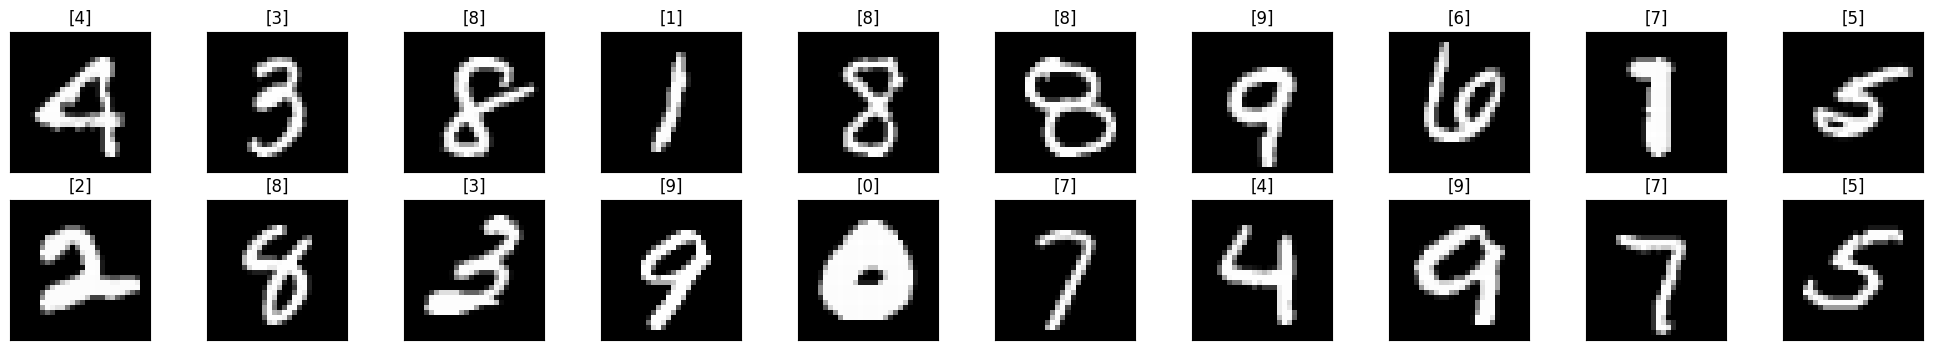

In [5]:
dataIter = iter(training_loader)
images, labels = next(dataIter)
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks = [],yticks = [])
  plt.imshow(image_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [38]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(50*4*4,500)
    self.fc2 = nn.Linear(500,10)
    self.dropout1 = nn.Dropout(p=0.5)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1,4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [39]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []



for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs,1)
    running_corrects += torch.sum(preds == labels.data)

    running_loss += loss.item()
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)


      val_epoch_loss = val_running_loss/len(validation_loader)
      val_epoch_accuracy = val_running_corrects.float()/len(validation_loader)
      val_running_corrects_history.append(val_epoch_accuracy.to("cpu"))
      val_running_loss_history.append(val_epoch_loss)




    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_accuracy.to("cpu"))

    print("Epoch: {}".format(e))
    print("Training Loss: {:.4f}, acc: {:.4f}".format(epoch_loss,epoch_accuracy.item()))
    print("Validation Loss: {:.4f}, acc: {:.4f}".format(val_epoch_loss,val_epoch_accuracy.item()))


Epoch: 0
Training Loss: 0.5613, acc: 84.9583
Validation Loss: 0.1734, acc: 95.1100


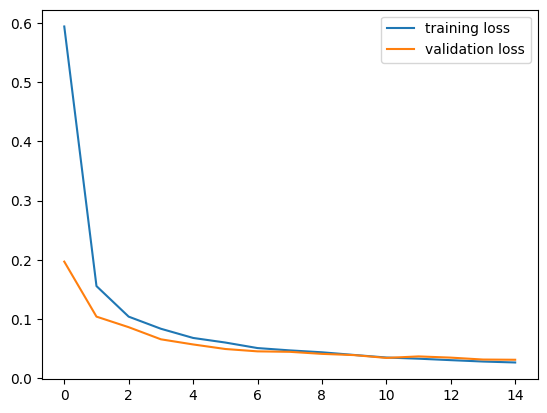

In [21]:
plt.plot(running_loss_history, label = "training loss")
plt.plot(val_running_loss_history,label="validation loss")
plt.legend()

In [26]:
plt.plot(val_running_corrects_history,label = "Validation_Accuracy")
plt.plot(running_corrects_history,label = "Training_Accuracy")


AttributeError: ignored

<Response [200]>


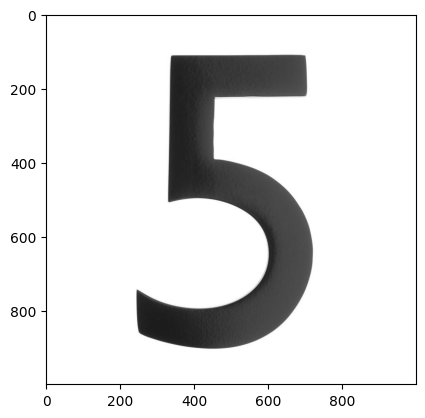

In [27]:
import requests
import PIL
from PIL import Image
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url,stream = True)
img = Image.open(response.raw)
print(response)
plt.imshow(img)

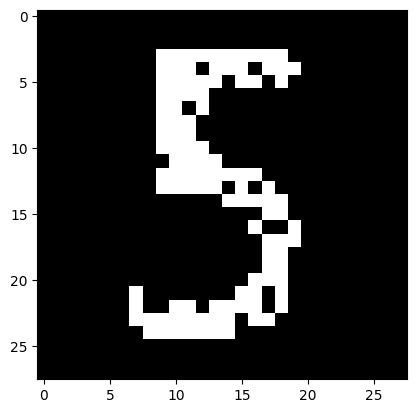

In [34]:
img2 = PIL.ImageOps.invert(img)
img2 = img2.convert('1')
img2 = transform(img2)
plt.imshow(image_convert(img2))

In [35]:
img2 = img2.to(device)
output = model(img2)
_, pred = torch.max(output,1)
print(pred.item())

5


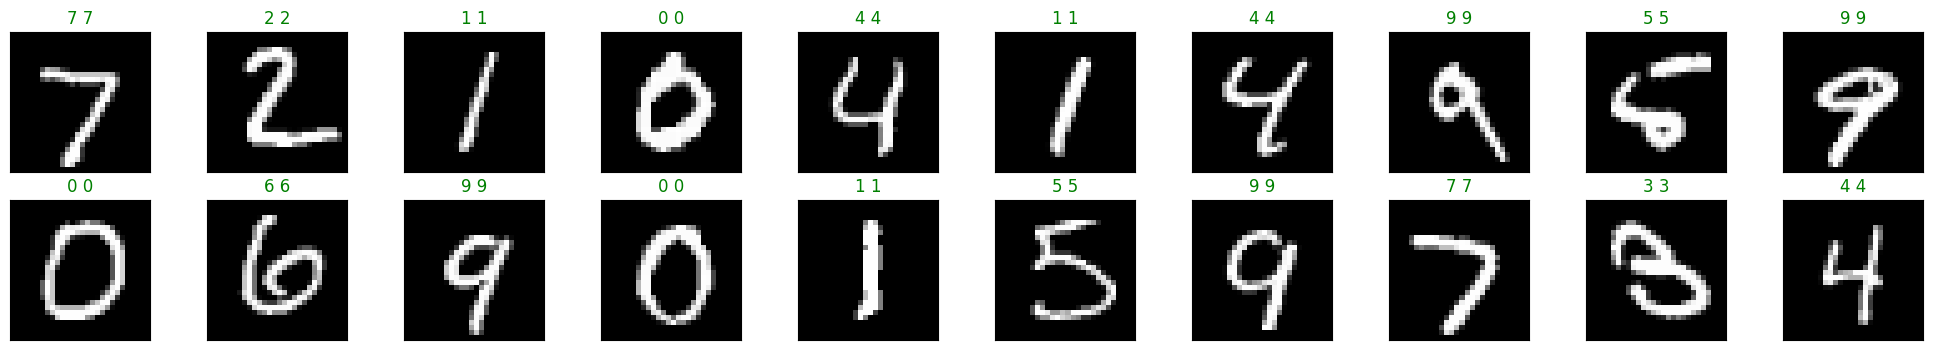

In [36]:
dataIter = iter(validation_loader)
images, labels = next(dataIter)
images_ = images.to(device)
output = model(images_)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks = [],yticks = [])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} {}".format(str(preds[idx].item()),str(labels[idx].item())),color=("green" if preds[idx] == labels[idx] else "red"))